# **Uncovering Bias and Explaining Decisions in a Text-Based Job-Screening Model**



**Institution:** Nile University

**Author:** Ahmad Gaballah

**Date:** July 6, 2025





#1. **Imports**

In [26]:
import os, random, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix
import shap
from tqdm import tqdm
from fairlearn.postprocessing import ThresholdOptimizer
from IPython.display import display


SEED = 2025
random.seed(SEED); np.random.seed(SEED)

#2. Train / Test Split

In [27]:
DATA_PATH = "data.csv"


df = pd.read_csv(DATA_PATH)
print(f"Loaded {df.shape[0]:,} rows × {df.shape[1]} columns")
display(df.head(3))

SENSITIVE_COL = "Gender"          # 1 = male, 0 = female
TARGET_COL    = "HiringDecision"  # 1 = Hire, 0 = Reject
FEATURE_COLS  = [c for c in df.columns if c not in [SENSITIVE_COL, TARGET_COL]]



Loaded 1,500 rows × 11 columns


,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0


# 3. Balanced TEST, 70 %-male-skewed TRAIN          

In [28]:
X = df[FEATURE_COLS];
y = df[TARGET_COL];
s = df[SENSITIVE_COL]


X_temp, X_test, y_temp, y_test, s_temp, s_test = train_test_split(
    X, y, s, test_size=0.30, stratify=s, random_state=SEED)


male_idx    = s_temp[s_temp == 1].index
female_idx  = s_temp[s_temp == 0].index

n_total     = len(s_temp)
n_male_tr   = int(0.70 * n_total)
n_female_tr = n_total - n_male_tr

def smart_sample(index_array, n_needed, seed=SEED):
    replace = n_needed > len(index_array)
    return np.random.RandomState(seed).choice(index_array,
                                              size=n_needed,
                                              replace=replace)

male_sample   = smart_sample(male_idx,   n_male_tr)
female_sample = smart_sample(female_idx, n_female_tr)

train_idx = np.concatenate([male_sample, female_sample])
np.random.shuffle(train_idx)

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]
s_train = s.loc[train_idx]

print("TRAIN gender distribution (target 70 % male):")
display(s_train.value_counts(normalize=True)
               .rename({1: "male", 0: "female"})
               .to_frame("proportion"))


TRAIN gender distribution (target 70 % male):


,proportion
Gender,
male,0.7
female,0.3


## Baseline Model — Logistic Regression
Pipeline:  
1. `StandardScaler` on all numeric features  
2. `LogisticRegression` with `class_weight="balanced"` to offset label skew  



=== Baseline Performance ===
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       320
           1       0.65      0.82      0.72       130

    accuracy                           0.82       450
   macro avg       0.78      0.82      0.80       450
weighted avg       0.84      0.82      0.83       450

Accuracy :  0.820
Precision: 0.650
Recall   :  0.815
F1 Score :  0.724
AUROC    : 0.896


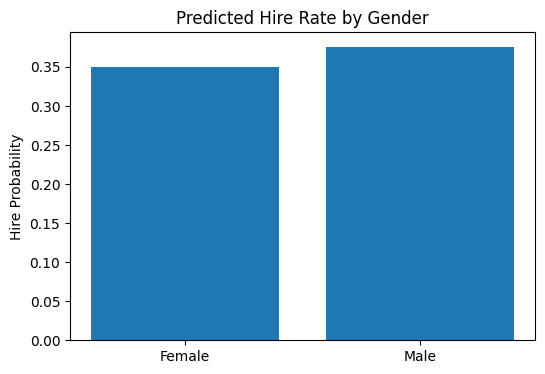

In [30]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in FEATURE_COLS if c not in num_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(
         handle_unknown='ignore',
         sparse_output=False
     ), cat_cols)
])


baseline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1_000,
        random_state=SEED
    ))
])


baseline.fit(X_train, y_train)

y_pred   = baseline.predict(X_test)
proba    = baseline.predict_proba(X_test)[:, 1]


print("=== Baseline Performance ===")
print(classification_report(y_test, y_pred))

acc   = accuracy_score(y_test, y_pred)
prec  = precision_score(y_test, y_pred)
rec   = recall_score(y_test, y_pred)
f1    = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, proba)

print(f"Accuracy : {acc: .3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec: .3f}")
print(f"F1 Score : {f1: .3f}")
print(f"AUROC    : {auroc:.3f}")


eval_df = pd.DataFrame({
    'pred'   : y_pred,
    'true'   : y_test.values,
    'gender' : s_test.values
})

hire_rates = eval_df.groupby('gender')['pred'].mean()

plt.figure(figsize=(6,4))
plt.bar(['Female','Male'], hire_rates)
plt.title('Predicted Hire Rate by Gender')
plt.ylabel('Hire Probability')
plt.show()

## Fairness Metric Suite
Calculates the three IEEE-recommended group fairness gaps  

(♂ minus ♀):  


| Metric | Formula | Intuition |
|--------|---------|-----------|
| **Demographic Parity** | P(ŷ=1\|male) − P(ŷ=1\|female) | Hiring rate gap |
| **Equal Opportunity**  | TPR_m − TPR_f | True-positive gap |
| **Average Odds**       | ½[(TPR_m − TPR_f) + (FPR_m − FPR_f)] | Balances TPR & FPR |




In [31]:
def demographic_parity(y_hat, sens, pos=1):
    return (y_hat[sens==1]==pos).mean() - (y_hat[sens==0]==pos).mean()
def equal_opportunity(y, y_hat, sens):
    tpr_m = ((y_hat==1)&(y==1)&(sens==1)).sum()/((y==1)&(sens==1)).sum()
    tpr_f = ((y_hat==1)&(y==1)&(sens==0)).sum()/((y==1)&(sens==0)).sum()
    return tpr_m - tpr_f
def avg_odds(y, y_hat, sens):
    fpr_m = ((y_hat==1)&(y==0)&(sens==1)).sum()/((y==0)&(sens==1)).sum()
    fpr_f = ((y_hat==1)&(y==0)&(sens==0)).sum()/((y==0)&(sens==0)).sum()
    return 0.5*(equal_opportunity(y, y_hat, sens) + (fpr_m - fpr_f))

def fairness_block(tag, y_true, y_hat, sens):
    dp = demographic_parity(y_hat,sens)
    eo = equal_opportunity(y_true,y_hat,sens)
    ao = avg_odds(y_true,y_hat,sens)
    print(f"\n{tag:^40}")
    print("─"*40)
    print(f"Demographic Parity : {dp:+.3f}")
    print(f"Equal Opportunity  : {eo:+.3f}")
    print(f"Average Odds       : {ao:+.3f}")
    return dp, eo, ao

gaps_base = fairness_block("BASELINE", y_test, y_pred_base, s_test)


                BASELINE                
────────────────────────────────────────
Demographic Parity : +0.026
Equal Opportunity  : +0.050
Average Odds       : +0.037


##  Explainability — SHAP Feature Attribution
Builds a **`LinearExplainer`** on the fitted logistic coefficients.  
For 5 representative resumes (3 *Hire*, 2 *Not-Hire*), we:  
1. Print the top-10 features driving the prediction  
2. Show an interactive SHAP bar plot  



                BASELINE                
────────────────────────────────────────
Demographic Parity : +0.026
Equal Opportunity  : +0.050
Average Odds       : +0.037


/usr/local/lib/python3.11/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]


Case 1 | Pred: Hire | True: Hire


,Feature,SHAP
6,num__SkillScore,1.046582
1,num__EducationLevel,0.791958
2,num__ExperienceYears,0.706332
5,num__InterviewScore,-0.485840
8,num__RecruitmentStrategy,-0.326601
3,num__PreviousCompanies,0.317204
7,num__PersonalityScore,0.149468
0,num__Age,0.083044
4,num__DistanceFromCompany,0.050456


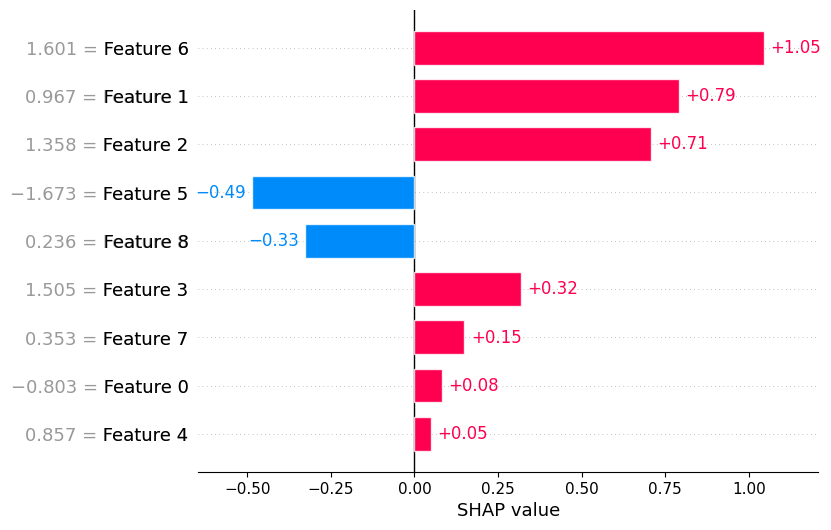


Case 2 | Pred: Hire | True: Hire


,Feature,SHAP
8,num__RecruitmentStrategy,2.420392
1,num__EducationLevel,1.794798
6,num__SkillScore,1.005336
2,num__ExperienceYears,-0.794815
7,num__PersonalityScore,0.393918
3,num__PreviousCompanies,0.328871
0,num__Age,-0.116036
4,num__DistanceFromCompany,0.114135
5,num__InterviewScore,-0.108172


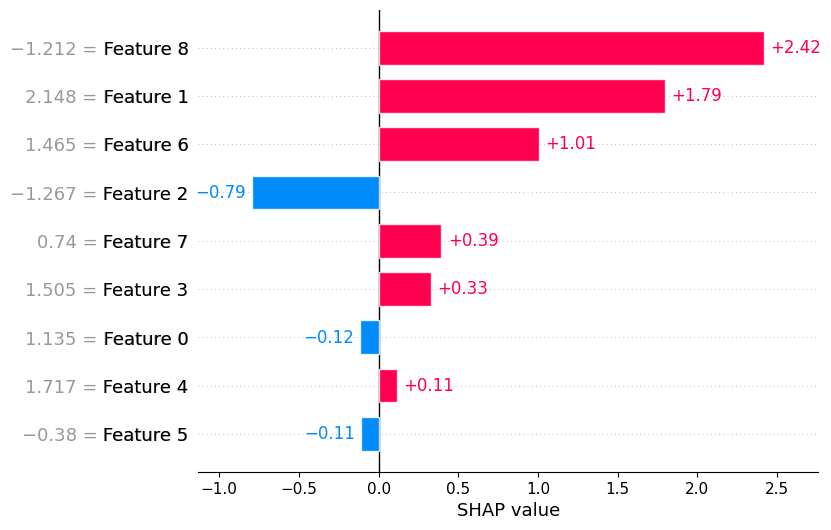


Case 5 | Pred: Hire | True: Hire


,Feature,SHAP
8,num__RecruitmentStrategy,2.167671
6,num__SkillScore,1.131719
2,num__ExperienceYears,0.933209
1,num__EducationLevel,0.882247
7,num__PersonalityScore,-0.623644
5,num__InterviewScore,0.316306
3,num__PreviousCompanies,0.157179
4,num__DistanceFromCompany,0.046845
0,num__Age,-0.015762


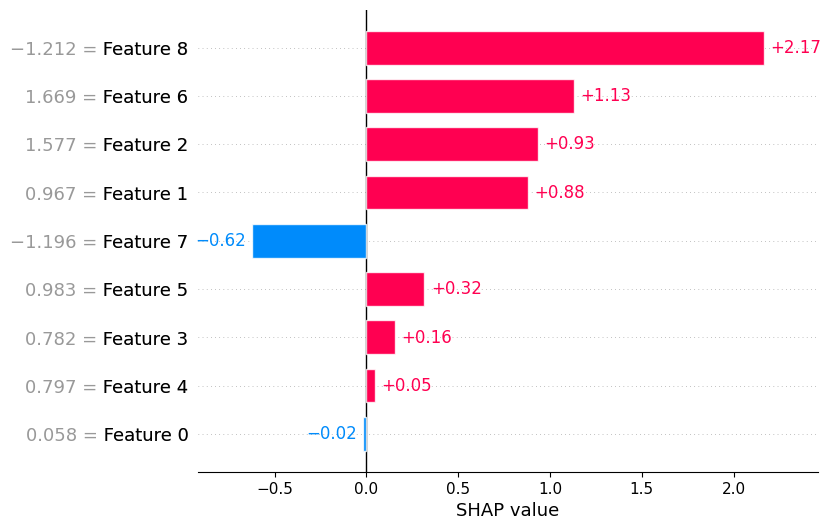


Case 0 | Pred: Not-Hire | True: Hire


,Feature,SHAP
8,num__RecruitmentStrategy,-2.819138
7,num__PersonalityScore,0.838250
6,num__SkillScore,-0.749451
1,num__EducationLevel,0.698184
5,num__InterviewScore,0.478837
0,num__Age,-0.075399
2,num__ExperienceYears,0.059818
4,num__DistanceFromCompany,-0.034660
3,num__PreviousCompanies,0.018920


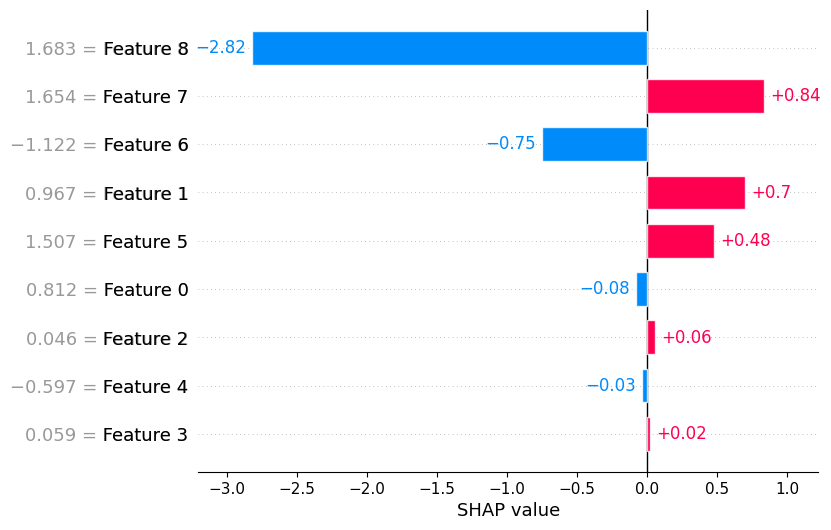


Case 3 | Pred: Not-Hire | True: Not-Hire


,Feature,SHAP
8,num__RecruitmentStrategy,-2.894406
1,num__EducationLevel,1.658101
6,num__SkillScore,-1.009182
2,num__ExperienceYears,0.603116
5,num__InterviewScore,-0.390247
3,num__PreviousCompanies,0.329590
7,num__PersonalityScore,0.124715
0,num__Age,0.100700
4,num__DistanceFromCompany,-0.096262


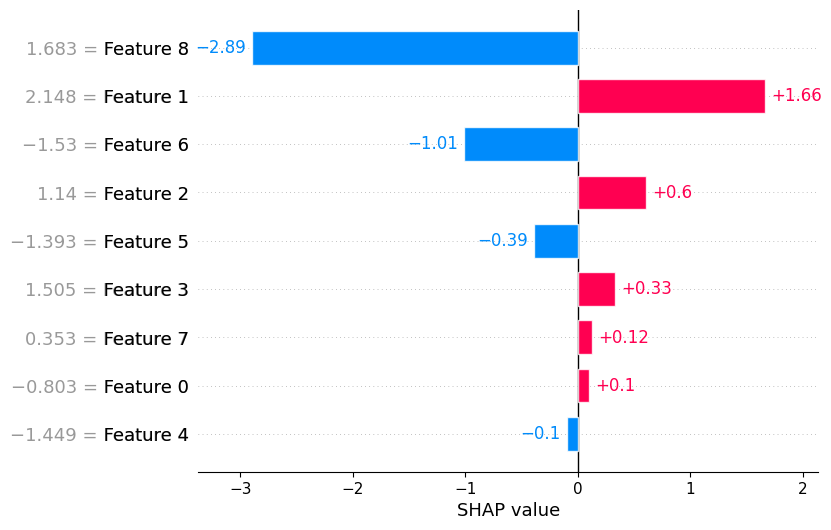

In [33]:
gaps_base = fairness_block("BASELINE", y_test, y_pred, s_test)


X_train_proc = baseline.named_steps['preprocessor'].transform(X_train)
X_test_proc  = baseline.named_steps['preprocessor'].transform(X_test)


feature_names = baseline.named_steps['preprocessor'].get_feature_names_out()


explainer = shap.LinearExplainer(
    baseline.named_steps['classifier'],
    X_train_proc,
    feature_perturbation="correlation_dependent"
)
shap.initjs()


results_df = pd.DataFrame({
    "idx":   np.arange(len(y_test)),
    "pred":  y_pred,
    "true":  y_test.reset_index(drop=True)
})

hire_idxs   = results_df[results_df["pred"]==1]["idx"].tolist()[:3]
nohire_idxs = results_df[results_df["pred"]==0]["idx"].tolist()[:2]
example_idxs = hire_idxs + nohire_idxs


def explain_idx(idx:int):
    true_lbl = "Hire"     if results_df.loc[idx,"true"] else "Not-Hire"
    pred_lbl = "Hire"     if results_df.loc[idx,"pred"] else "Not-Hire"
    print(f"\n{'='*60}\nCase {idx} | Pred: {pred_lbl} | True: {true_lbl}")
    shap_val = explainer(X_test_proc[idx:idx+1])
    df_contrib = (
        pd.DataFrame({"Feature": feature_names, "SHAP": shap_val.values[0]})
          .assign(abs=lambda d: d["SHAP"].abs())
          .sort_values("abs", ascending=False)
          .head(10)
          .drop(columns="abs")
    )
    display(df_contrib)
    shap.plots.bar(shap_val[0], max_display=10)

for i in example_idxs:
    explain_idx(i)


## Bias Mitigation — Reweighing
Re-trains the logistic model using sample weights  

Outputs mitigated accuracy and the same three fairness gaps for side-by-side comparison.


In [34]:
group_counts = s_train.value_counts().to_dict()
N = len(s_train)
w_balanced = s_train.map({g: N/(2*c) for g,c in group_counts.items()})
lambdas = np.linspace(0,1,11)
records=[]
for lam in lambdas:
    w_lam = (1-lam)*1 + lam*w_balanced
    model = Pipeline([
        ("prep", numeric_processor),
        ("clf", LogisticRegression(max_iter=1200, random_state=SEED))
    ])
    model.fit(X_train, y_train, clf__sample_weight=w_lam)
    y_hat = model.predict(X_test)
    acc   = accuracy_score(y_test, y_hat)
    records.append([lam, acc,
                    demographic_parity(y_hat,s_test),
                    equal_opportunity(y_test,y_hat,s_test),
                    avg_odds(y_test,y_hat,s_test)])
df_sweep = pd.DataFrame(records, columns=["λ","Acc","DP","EO","AO"])
display(df_sweep.style.format({"Acc":"{:.3f}","DP":"{:+.3f}",
                               "EO":"{:+.3f}","AO":"{:+.3f}"}))


candidates = df_sweep[df_sweep["EO"].abs()<=0.05]
if len(candidates):
    best_row = candidates.sort_values("Acc",ascending=False).iloc[0]
    best_lam = best_row["λ"]
else:
    best_row = df_sweep.sort_values("EO", key=lambda x:x.abs()).iloc[0]
    best_lam = best_row["λ"]

print(f"\n Selected λ = {best_lam:.2f}  "
      f"(Acc = {best_row['Acc']:.3f}, EO = {best_row['EO']:+.3f})")

w_final = (1-best_lam)*1 + best_lam*w_balanced
fair_model = Pipeline([
    ("prep", numeric_processor),
    ("clf",  LogisticRegression(max_iter=1200, random_state=SEED))
])
fair_model.fit(X_train, y_train, clf__sample_weight=w_final)
y_fair = fair_model.predict(X_test)
proba_fair = fair_model.predict_proba(X_test)[:,1]
gaps_fair = fairness_block("RE-WEIGHED", y_test, y_fair, s_test)
acc_fair  = accuracy_score(y_test, y_fair)
print(f"\nAccuracy | Baseline: {acc_base:.3f}  →  Re-weighed: {acc_fair:.3f}")




,λ,Acc,DP,EO,AO
0,0.000000,0.878,+0.005,+0.062,+0.026
1,0.100000,0.878,+0.005,+0.062,+0.026
2,0.200000,0.876,+0.001,+0.046,+0.018
3,0.300000,0.876,+0.001,+0.046,+0.018
4,0.400000,0.876,+0.001,+0.046,+0.018
5,0.500000,0.876,+0.001,+0.046,+0.018
6,0.600000,0.873,+0.005,+0.046,+0.021
7,0.700000,0.871,+0.001,+0.046,+0.018
8,0.800000,0.871,+0.001,+0.046,+0.018
9,0.900000,0.871,+0.001,+0.046,+0.018



 Selected λ = 0.20  (Acc = 0.876, EO = +0.046)

               RE-WEIGHED               
────────────────────────────────────────
Demographic Parity : +0.001
Equal Opportunity  : +0.046
Average Odds       : +0.018

Accuracy | Baseline: 0.820  →  Re-weighed: 0.876


##  Fairness Gap Reduction Visual
Bar chart of Demographic Parity, Equal Opportunity, and Average Odds  
**before** vs. **after** mitigation.  
Zero line marks perfect parity; narrower bars = fairer model.


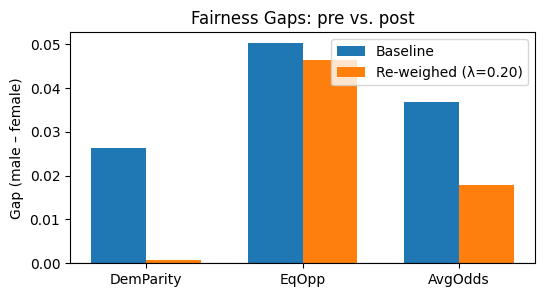

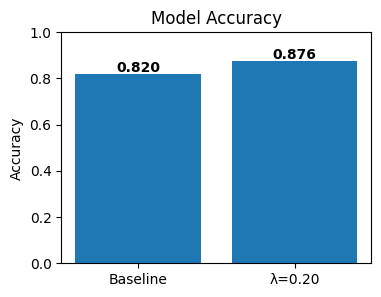

In [35]:
labels = ["DemParity","EqOpp","AvgOdds"]
x = np.arange(len(labels)); w=0.35
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(x-w/2, gaps_base, w, label="Baseline")
ax.bar(x+w/2, gaps_fair, w, label=f"Re-weighed (λ={best_lam:.2f})")
ax.axhline(0,color="black",lw=0.8); ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_ylabel("Gap (male – female)"); ax.legend()
plt.title("Fairness Gaps: pre vs. post"); plt.show()

fig, ax = plt.subplots(figsize=(4,3))
ax.bar(["Baseline", f"λ={best_lam:.2f}"], [acc_base, acc_fair])
ax.set_ylim(0,1); ax.set_ylabel("Accuracy"); ax.set_title("Model Accuracy")
for i,v in enumerate([acc_base, acc_fair]):
    ax.text(i, v+0.01, f"{v:.3f}", ha="center", fontweight="bold")
plt.show()